## Multi-class classification with XGBoost--Feature engineering and model training 

Steps: (1) Load dataset from s3 onto the notebook, (2) clean, transform, analyze and prepare the dataset, (3) create and train model with XGBoost algorithm

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import io
from datetime import datetime

import boto3, sagemaker
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac


### Step 1: Load the dataset from S3 onto the notebook

In [2]:
role = get_execution_role()
bucket = 'ml-projects-bl'
sub_folder = 'ufo_dataset'
data_key = 'ufo_fullset.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)

df = pd.read_csv(data_location, low_memory=False)
df.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


### Step 2: Clean, Transform, Analyze, and Prepare the dataset

First check if there are missing values

In [3]:
missing_values = df.isnull().values.any()
if(missing_values):
    display(df[df.isnull().any(axis=1)])

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
1024,2011-03-23T18:32:20.473Z,2011-03-22,21:12,NaN,3,1,rain,Deon,Feil,37.681944,-121.766944,Y,N,N,explained
2048,1998-04-23T18:47:16.029Z,1998-04-23,10:07,NaN,40,2,partly cloudy,Vincenzo,Rohan,38.254167,-85.759444,Y,Y,N,explained


There are 2 records with missing values of 'shape'. Now to check which the shapes are and their occurrances.

In [5]:
df['shape'].value_counts()

circle      6047
disk        5920
light       1699
square      1662
triangle    1062
sphere      1020
box          200
oval         199
pyramid      189
Name: shape, dtype: int64

replace the missing shape values with the most common shape which is circle

In [6]:
df['shape'] = df['shape'].fillna(df['shape'].value_counts().index[0])

now start data transformation: (1) convert the data types of reportedTimestamp and eventDate to datetime (2) convert the data type of shape and weather to category data type, (3) map physicalEvidence and contact from 'Y', 'N, to 1, 0, (4) convert researchOutcome to category data type as target attribute.

In [7]:
df['reportedTimestamp'] = pd.to_datetime(df['reportedTimestamp'])
df['eventDate'] = pd.to_datetime(df['eventDate'])

In [9]:
df['shape'] = df['shape'].astype('category')
df['weather'] = df['weather'].astype('category')

In [10]:
df['physicalEvidence'] = df['physicalEvidence'].replace({'Y':1, 'N':0})
df['contact'] = df['contact'].replace({'Y':1, 'N':0})

In [11]:
df['researchOutcome'] = df['researchOutcome'].astype('category')

In [13]:
df.dtypes

reportedTimestamp    datetime64[ns, UTC]
eventDate                 datetime64[ns]
eventTime                         object
shape                           category
duration                           int64
witnesses                          int64
weather                         category
firstName                         object
lastName                          object
latitude                         float64
longitude                        float64
sighting                          object
physicalEvidence                   int64
contact                            int64
researchOutcome                 category
dtype: object

now review the data through visualization and find out useful info as input for data preparation

In [15]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

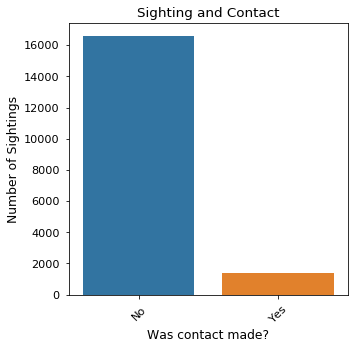

In [16]:
m_cts = (df['contact'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('Sighting and Contact')
ax.set_xlabel('Was contact made?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

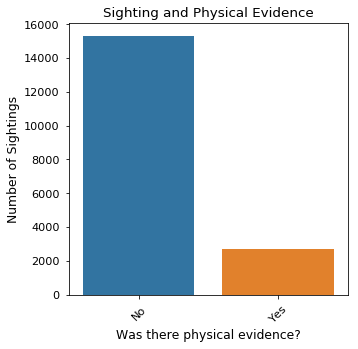

In [17]:
m_cts = (df['physicalEvidence'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('Sighting and Physical Evidence')
ax.set_xlabel('Was there physical evidence?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

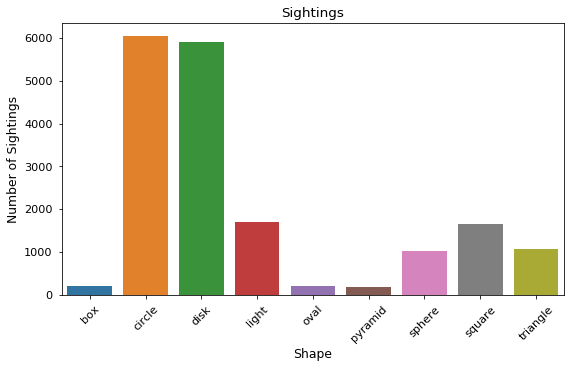

In [18]:
m_cts = (df['shape'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(9,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('Sightings')
ax.set_xlabel('Shape')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

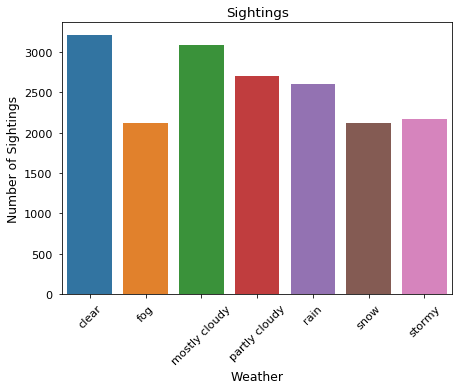

In [20]:
m_cts = (df['weather'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(7,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('Sightings')
ax.set_xlabel('Weather')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

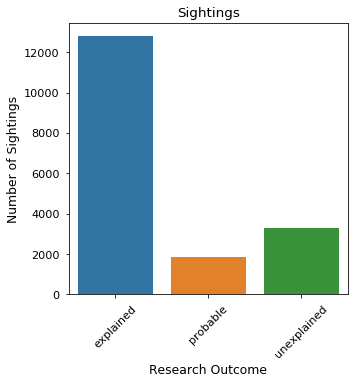

In [22]:
m_cts = (df['researchOutcome'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)

ax.set_title('Sightings')
ax.set_xlabel('Research Outcome')
ax.set_ylabel('Number of Sightings')

plt.xticks(rotation=45)
plt.show()

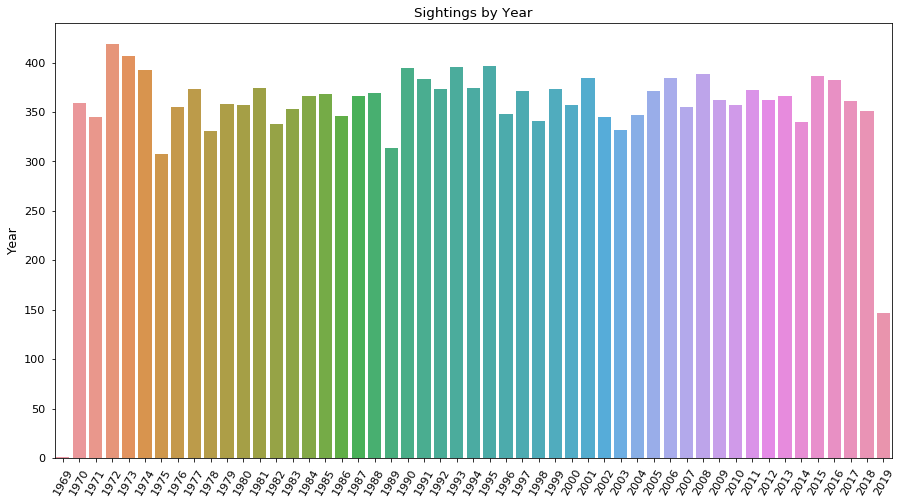

In [24]:
ufo_yr = df['eventDate'].dt.year

years_data = ufo_yr.value_counts()
years_index = years_data.index
years_values = years_data.get_values()

plt.figure(figsize=(15,8))
plt.xticks(rotation=60)
plt.title('Sightings by Year')
plt.ylabel('Number of Sightings')
plt.ylabel('Year')

years_plot = sns.barplot(x=years_index[:60], y=years_values[:60])

In [25]:
df.corr()

,duration,witnesses,latitude,longitude,physicalEvidence,contact
duration,1.000000,0.020679,0.000243,-0.010529,0.016430,0.015188
witnesses,0.020679,1.000000,0.010229,0.003449,0.009186,-0.000651
latitude,0.000243,0.010229,1.000000,-0.394536,0.006465,0.004284
longitude,-0.010529,0.003449,-0.394536,1.000000,-0.004519,-0.004828
physicalEvidence,0.016430,0.009186,0.006465,-0.004519,1.000000,0.693276
contact,0.015188,-0.000651,0.004284,-0.004828,0.693276,1.000000


now drop the columns that are not important. (1) drop 'sighting' because it is always 'Yes'; (2) drop first name and last name because these are not important with regards to the reserachOutcome; (3) drop reportedTimestamp because the time of sighting deoes not help to determine the legitimacy of the sighting, (4) if the eventDate and eventTime are not evenly distributed, it may helps if some sort of buckets (e.g., seasons) can be created, but since the eventDate and envetTime are pretty evenly distributed, they can be dropped too.

In [26]:
df.drop(columns=['firstName', 'lastName', 'sighting', 'reportedTimestamp', 'eventDate', 'eventTime'], inplace=True)

In [27]:
df.head()


,shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome
0,circle,4,1,rain,47.329444,-122.578889,0,0,explained
1,disk,4,1,partly cloudy,52.664913,-1.034894,1,0,explained
2,circle,49,1,clear,38.951667,-92.333889,0,0,explained
3,disk,13,1,partly cloudy,41.496944,-71.367778,0,0,explained
4,circle,17,1,mostly cloudy,47.606389,-122.330833,0,0,explained


Now apply one-hot encoding for categorical values: (1) apply one-hot encoding for both weather and shape attributes; (2) map researchOutcome (target) into numerical values.

In [28]:
df = pd.get_dummies(df, columns=['weather', 'shape'])

In [29]:
df['researchOutcome'] = df['researchOutcome'].replace({'unexplained':0, 'explained':1, 'probable':2})

In [30]:
display(df.head())


,duration,witnesses,latitude,longitude,physicalEvidence,contact,researchOutcome,weather_clear,weather_fog,weather_mostly cloudy,...,weather_stormy,shape_box,shape_circle,shape_disk,shape_light,shape_oval,shape_pyramid,shape_sphere,shape_square,shape_triangle
0,4,1,47.329444,-122.578889,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4,1,52.664913,-1.034894,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,49,1,38.951667,-92.333889,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,13,1,41.496944,-71.367778,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,17,1,47.606389,-122.330833,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [31]:
display(df.shape)

(18000, 23)

Now start training. Randomize and split the data for training, calidation and testing.(1) Randomize the data; (2) split the data to use 80% for training, 10% for validation during training, and 10% for testing the model after it is deployed

In [32]:
#Randomize the dataset
df = df.sample(frac=1).reset_index(drop=True)

In [33]:
#split the data for training, validation and testing
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

In [34]:
data_train = df[train_list]
data_val = df[val_list]
data_test = df[test_list]

Now rmake the target attribute researchOutcome as the first attribute according to the requiremnts set by AWS documentations, which is also that the XGBoost algorithm expects. After this, the datasets will be stored as csv format in S3

In [35]:
# Simply moves the researchOutcome attribute to the first position before creating csv files
pd.concat([data_train['researchOutcome'], data_train.drop(['researchOutcome'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([data_val['researchOutcome'], data_val.drop(['researchOutcome'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

# Next take the files that have just been stored onto the Notebook instance and upload them to S3.
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab_922/xgboost_train/train.csv').upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab_922/xgboost_validation/validation.csv').upload_file('validation.csv')

### Step 3: Create and train XGBoost mode

Now get tthe ECR container hosted in ECR for the XGBoost algorithm

In [37]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

because training data is in csv format, it will need to create inputs that the training function can use as a pointer to the files in S3, which also specify that the content type is csv.

In [38]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/algorithms_lab_922/xgboost_train'.format(bucket), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/algorithms_lab_922/xgboost_validation'.format(bucket), content_type='csv')

Now to start building out the model by using the SageMaker Python SDK and passing in everything that is required to create a XGBoost model.

First create a specific job name.

Then specify the training parameters.

The xgboost algorithm container
The IAM role to use
Training instance type and count
S3 location for output data/model artifact
XGBoost Hyperparameters

Finally, after everything is included and ready, it's time to call the .fit() function which specifies the S3 location for training and validation data.


In [39]:
# create a training job name
job_name = 'ufo-xgboost-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model artifact will be stored
output_location = 's3://{}/algorithms_lab_922/xgboost_output'.format(bucket)

Here is the job name ufo-xgboost-job-20190923053125


In [40]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

xgb.set_hyperparameters(objective='multi:softmax',
                        num_class=3,
                        num_round=100)

data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation
}
xgb.fit(data_channels, job_name=job_name)

2019-09-23 05:31:42 Starting - Starting the training job...
2019-09-23 05:31:45 Starting - Launching requested ML instances......
2019-09-23 05:32:47 Starting - Preparing the instances for training......
2019-09-23 05:33:57 Downloading - Downloading input data
2019-09-23 05:33:57 Training - Downloading the training image..2019-09-23 05:34:16,310 sagemaker-containers INFO     Imported framework sagemaker_xgboost_container.training
2019-09-23 05:34:16,311 sagemaker-containers INFO     Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
2019-09-23 05:34:16,314 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-09-23 05:34:16,328 sagemaker_xgboost_container.training INFO     Running XGBoost Sagemaker in algorithm mode
2019-09-23 05:34:16,331 root         INFO     Determined delimiter of CSV input is ','
2019-09-23 05:34:16,331 root         ERROR    1,85,7,34.228333299999996,-118.5358333,0,0,0,0,1,0,0,0,0,0,0,1,0,0,

In [41]:
print('This is the location of the trained XGBoost model: {}/{}/output/model.tar.gz'.format(output_location, job_name))

This is the location of the trained XGBoost model: s3://ml-projects-bl/algorithms_lab_922/xgboost_output/ufo-xgboost-job-20190923053125/output/model.tar.gz
